# _PROJECT_: Prediction Error $-$ Belief replication 

In [1]:
# Core analysis packages

from pandas import ExcelWriter
from pandas import ExcelFile
from statsmodels.formula.api import ols
import pingouin as pg
import researchpy

import numpy as np
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

## 1 $-$ Reshape data matrix into data column

In [3]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("~/Desktop/PBArep.xlsx"), index_col=0)
df.head()

,Date,study,cond,party,CHANGE,1N,2N,3N,4N,5N,...,3R.2,4R.2,5R.2,6R.2,7R.2,8R.2,9R.2,10R.2,11R.2,12R.2
Response ID,,,,,,,,,,,,,,,,,,,,,
Over_Under,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0,...,1,0,0,0,1,1,1,0,0,0
Support_Against,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
Dem_Rep_Ind,NaN,NaN,NaN,NaN,NaN,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
R_Q05BXFYLTih4gdr,1.0,2.0,2.0,1.0,NaN,3,9,99,-3,17,...,82,74,6,11,7,20,73,69,38,0
R_3CMkUHMX39AaEEh,1.0,2.0,2.0,1.0,NaN,72,40,70,-44,51,...,17,3,25,72,52,17,1,32,20,36


#### 1a $-$ Unpack data from dataframe
In general, this code will change from project to project, based on data labels, partitions, etc.

We want to use the row/column labels printed in the header above to extract data (typically matrices) and data labels (typically vectors). In this case, participants are rows and items are columns, which means participant-based labels are columns and item-based labels are rows.

In [4]:
# Extract rows with df.loc["target",:], only grabbing data corresponding to items
nitemlabel = 3
overunder = df.loc["Over_Under", "1N":"12R"]
supportagainst = df.loc["Support_Against", "1N":"12R"]
itemideology = df.loc["Dem_Rep_Ind", "1N":"12R"]
itemnum = np.arange(itemideology.size)
# Additional info (maximum achievable PE)
maxPE = np.array([10,9,7,6,8,11,8,6,11,10,9,7,9,7,10,6,8,11,11,8,6,9,10,7,7,9,10,8,11,6,11,8,6,7,10,9])
# Then remove these rows from the dataframe and continue
dftrim = df.iloc[nitemlabel:, :]

# Extract columns with df.target or df["target"] or df.loc[:,"target"]
date = dftrim.loc[:, "Date"]
study = dftrim.loc[:, "study"]
cond = dftrim.loc[:, "cond"]
partideology = dftrim.loc[:, "party"]
#resist = dftrim.loc[:, "BeliefResistance"]
#president = dftrim.loc[:, "SupportTrump"]
#partystr = dftrim.loc[:, "PartyStrength"]
#vote = dftrim.loc[:, "votereg"]
partnum = np.arange(partideology.size)

# Extract data with df.loc[:,"datastart":"dataend"]
deltaB = dftrim.loc[:, "1N":"12R"]
signedPE = dftrim.loc[:, "1N.1":"12R.1"]
PE = signedPE.abs().astype(int)
Bpre = dftrim.loc[:, "1N.2":"12R.2"]
sz = deltaB.shape
print(sz)

(1073, 36)


#### 1b $-$ Repack data into new dataframe in column-form
First, we expand every piece of data unpacked above to match the shape of the data. Then, we reshape all of them into columns and combine into a new dataset ready for analysis.

In [5]:
names = ["deltaB", "signedPE", "PE", "Bpre", "overunder", "supportagainst", "itemideology", "maxPE", "itemnum", \
         "date", "study", "cond", "partideology", "partnum"]
data_packed = np.broadcast_arrays(deltaB, signedPE, PE, Bpre, overunder, supportagainst, itemideology, maxPE, itemnum)
cols = [np.tile(a, (sz[1],1)).T for a in [date, study, cond, partideology, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

#### 1c $-$ Rational update direction

"Rational" update reflects a resigning of each belief change such that the "rational" direction is always positive. If a participant has a huge underestimated PE of evidence that refutes the belief, for example, the rational response is to decrease the belief; in data analysis terms, we multiply this belief change by $-1$:

$$\textsf{Rational }\Delta B = \textsf{sign}({Support/Against})\cdot\textsf{sign}({Over/Under})\cdot\textsf{sign}({PE})\cdot\Delta B$$

In [6]:
# We add a small positive number to prediction errors such that sign(0) = 1
RUD = np.sign(DATA["supportagainst"] - 0.5) * np.sign(DATA["overunder"] - 0.5) * np.sign(DATA["signedPE"] + 0.01)
RUD_control = np.sign(DATA["supportagainst"] - 0.5)
RUD[DATA["cond"]==2] = RUD_control[DATA["cond"]==2]
# Rational belief update
RdeltaB = DATA["deltaB"]*RUD
if "RdeltaB" in DATA:
    DATA["RdeltaB"] = RdeltaB
else:
    DATA.insert(0, "RdeltaB", RdeltaB)
# Rational update interval
RpreI = np.abs((RUD+1)*50 - DATA["Bpre"])
if "RpreI" in DATA:
    DATA["RpreI"] = RpreI
else:
    DATA.insert(5, "RpreI", RpreI)
if "RpreI" in DATA:
    DATA["RpreI"] = RpreI
else:
    DATA.insert(5, "RpreI", RpreI)

DATA.head()

,RdeltaB,deltaB,signedPE,PE,Bpre,RpreI,overunder,supportagainst,itemideology,maxPE,itemnum,date,study,cond,partideology,partnum
0,3.0,3.0,0.0,0.0,66.0,34.0,1.0,1.0,3.0,10.0,0.0,1.0,2.0,2.0,1.0,0.0
1,9.0,9.0,0.0,0.0,69.0,31.0,1.0,1.0,3.0,9.0,1.0,1.0,2.0,2.0,1.0,0.0
2,99.0,99.0,0.0,0.0,1.0,99.0,1.0,1.0,3.0,7.0,2.0,1.0,2.0,2.0,1.0,0.0
3,-3.0,-3.0,0.0,0.0,74.0,26.0,0.0,1.0,3.0,6.0,3.0,1.0,2.0,2.0,1.0,0.0
4,17.0,17.0,0.0,0.0,66.0,34.0,0.0,1.0,3.0,8.0,4.0,1.0,2.0,2.0,1.0,0.0


## 3 $-$ Plot belief vs. PE
First, we transform the raw PEs into bins in a new column of the dataframe. Then, we can use seaborn to make simple barplots.

In [7]:
bins = [[0],[1,2,3,4,5],[6,7,8,9,10,11]]
binedges = [a[0] - 0.5 for a in bins] + [bins[-1][-1] + 0.5]
# Digitize the prediction 
binnedPE = np.digitize(DATA["PE"], binedges)-1
# Force control condition to be bin "3" (the rightmost bin)
binnedPE[DATA["cond"]==2] = 3
DATA.insert(3,"binnedPE",binnedPE)

In [8]:
makeslargePEs = np.unique(np.array(DATA.loc[DATA["binnedPE"]==2, "partnum"]))
canmakelargePEs = np.unique(np.array(DATA.loc[DATA["cond"]==1, "partnum"]))
print(np.setdiff1d(canmakelargePEs, makeslargePEs))

[]


In [9]:
DATA.head()

,RdeltaB,deltaB,signedPE,binnedPE,PE,Bpre,RpreI,overunder,supportagainst,itemideology,maxPE,itemnum,date,study,cond,partideology,partnum
0,3.0,3.0,0.0,3,0.0,66.0,34.0,1.0,1.0,3.0,10.0,0.0,1.0,2.0,2.0,1.0,0.0
1,9.0,9.0,0.0,3,0.0,69.0,31.0,1.0,1.0,3.0,9.0,1.0,1.0,2.0,2.0,1.0,0.0
2,99.0,99.0,0.0,3,0.0,1.0,99.0,1.0,1.0,3.0,7.0,2.0,1.0,2.0,2.0,1.0,0.0
3,-3.0,-3.0,0.0,3,0.0,74.0,26.0,0.0,1.0,3.0,6.0,3.0,1.0,2.0,2.0,1.0,0.0
4,17.0,17.0,0.0,3,0.0,66.0,34.0,0.0,1.0,3.0,8.0,4.0,1.0,2.0,2.0,1.0,0.0


In [12]:
%load_ext rpy2.ipython
%R library(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [13]:
%Rpush DATA

In [14]:
anovaDATA = DATA.loc[DATA["cond"]==1, :]

%Rpush anovaDATA

In [15]:
%%R

anova(lmer(RdeltaB ~ PE*partideology + (1|partnum) + (1|itemnum), data=anovaDATA))


Type III Analysis of Variance Table with Satterthwaite's method
                Sum Sq Mean Sq NumDF   DenDF  F value    Pr(>F)    
PE              118021  118021     1 22258.2 123.8459 < 2.2e-16 ***
partideology      4028    4028     1  2179.4   4.2269  0.039908 *  
PE:partideology   8659    8659     1 22244.7   9.0867  0.002578 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R

anova(lmer(RdeltaB ~ itemideology*binnedPE*partideology + (1|partnum), data=anovaDATA))

Type III Analysis of Variance Table with Satterthwaite's method
                                   Sum Sq Mean Sq NumDF DenDF F value  Pr(>F)  
itemideology                        642.2   642.2     1 22021  0.6170 0.43217  
binnedPE                           2755.5  2755.5     1 22101  2.6473 0.10374  
partideology                       4465.1  4465.1     1 21429  4.2897 0.03835 *
itemideology:binnedPE              5155.7  5155.7     1 22081  4.9532 0.02605 *
itemideology:partideology          1725.3  1725.3     1 22022  1.6575 0.19795  
binnedPE:partideology                17.1    17.1     1 22098  0.0165 0.89791  
itemideology:binnedPE:partideology  101.9   101.9     1 22081  0.0979 0.75443  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### Main effect

In [17]:
#DATA.groupby(['binnedPE']).size() / (620*36)
DATA.groupby(['partideology', 'itemideology', 'binnedPE']).size() / (12 * 296)

partideology  itemideology  binnedPE
1.0           1.0           0           0.096847
                            1           0.666667
                            2           0.331081
                            3           0.770270
              2.0           0           0.110642
                            1           0.681025
                            2           0.302928
                            3           0.770270
              3.0           0           0.098536
                            1           0.698761
                            2           0.297297
                            3           0.770270
2.0           1.0           0           0.086430
                            1           0.637950
                            2           0.275619
                            3           0.760135
              2.0           0           0.092905
                            1           0.630068
                            2           0.277027
                            3   

<IPython.core.display.Javascript object>


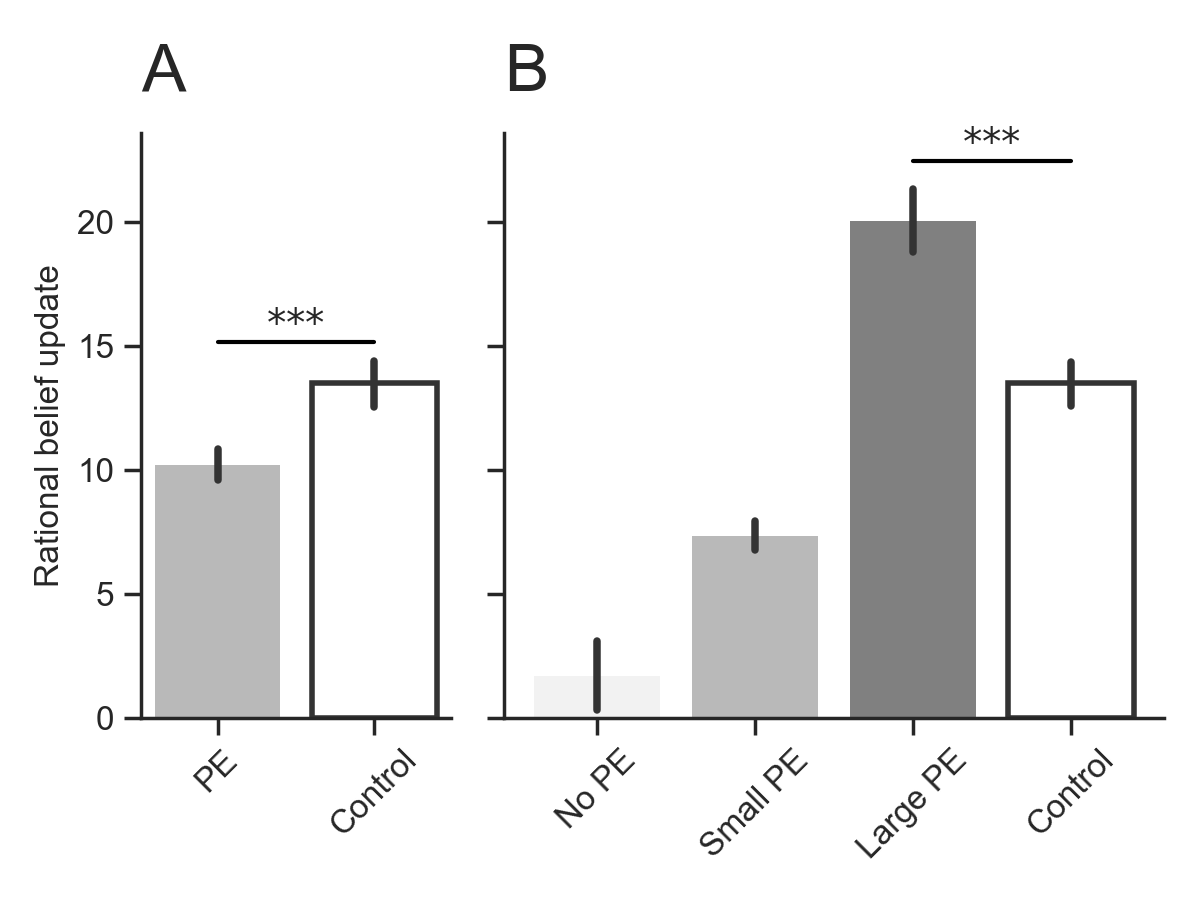

In [18]:
# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum"], as_index=False).mean()
# Plotting
fig, ax = plt.subplots(1,2, figsize=(6,4.5), gridspec_kw={"width_ratios": [1,2.125]}, sharey=True)
cust_palette = [sns.light_palette("gray", n_colors=len(bins))[1]] + [np.array([1, 1, 1, 0])]
sns.barplot(x="cond", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = [0,2], edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
sns.despine()
ax[0].set_xlabel("");
ax[0].set_xticklabels(["PE","Control"], rotation=45);
ax[0].set_ylabel("Rational belief update");
# Significance testing
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["cond"]==1, "RdeltaB"], \
                       AVDATA.loc[AVDATA["cond"]==2, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)
plt.tight_layout()
bff.panellabel(ax[0], "A")



# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum", "binnedPE"], as_index=False).mean()
# Plotting
cust_palette = sns.light_palette("gray", n_colors=len(bins)) + [np.array([1, 1, 1, 0])]
sns.barplot(x="binnedPE", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = [0]*len(bins) + [2], edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.despine()
ax[1].set_xlabel("");
ax[1].set_xticklabels(["No PE","Small PE","Large PE","Control"], rotation=45);
ax[1].set_ylabel("");
# Significance testing
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["binnedPE"]==2, "RdeltaB"], \
                       AVDATA.loc[AVDATA["binnedPE"]==3, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[1], 2, 3, p, datahandles, dh=0.05, fs=14)
plt.tight_layout()
bff.panellabel(ax[1], "B")

#plt.savefig('/Users/mada/Desktop/fig2rep.tif', dpi=300, format="tiff")

#### Main effect, split by participant $\times$ item ideology

<IPython.core.display.Javascript object>


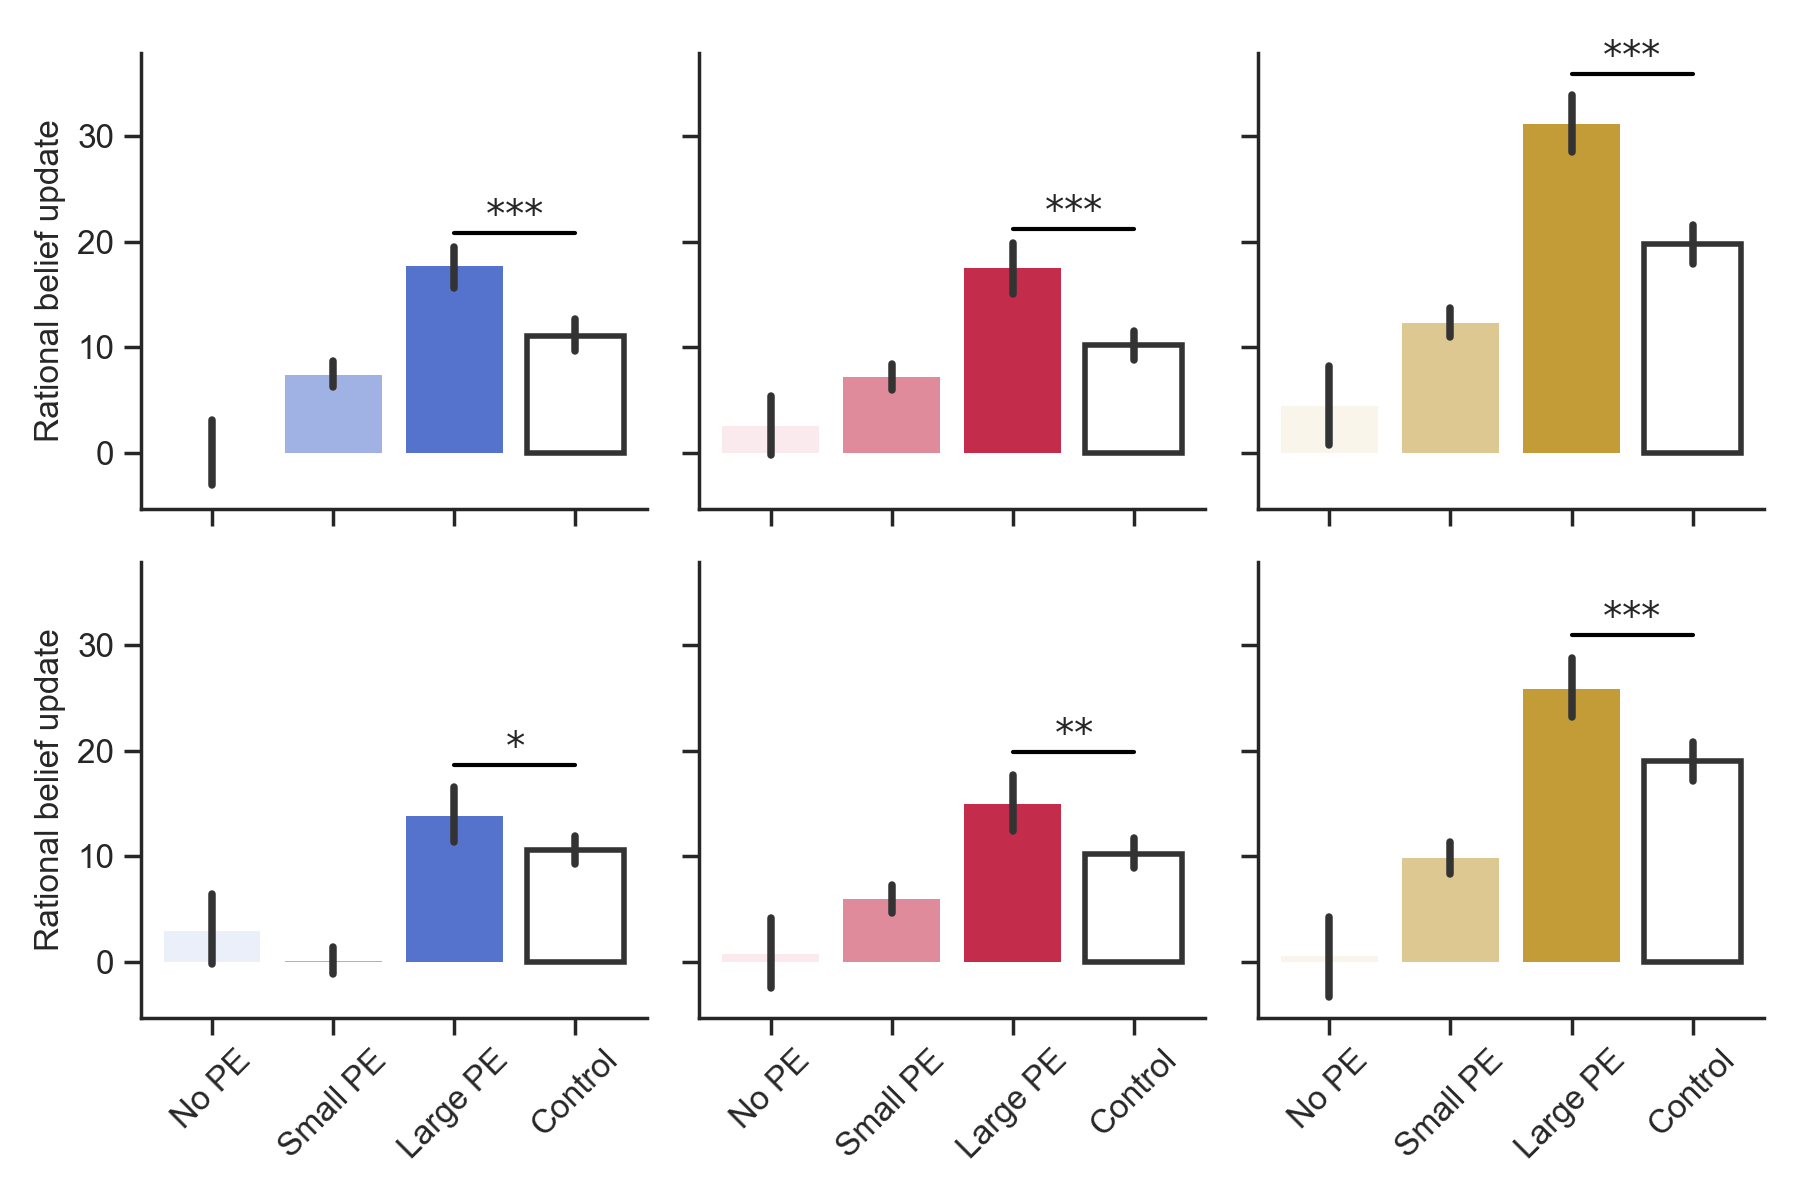

In [19]:
# Declare groups over which to split here:
grp1 = "partideology"
grp2 = "itemideology"

fig, ax = plt.subplots(len(DATA[grp1].unique()), len(DATA[grp2].unique()), figsize=(9,6), sharey=True)
colors = ["royalblue", "crimson", "goldenrod"]

# Split dataframe into groups, where grpDATA is a subsampled dataframe of DATA with one split's data at a time
svals = []
for name, grpDATA in DATA.groupby([grp1, grp2]):
    name = np.array(name, dtype=int) - 1
    cax = ax[name[0],name[1]]
    # Average the split's items within participants
    AVDATA = grpDATA.groupby(["partnum", "binnedPE"], as_index=False).mean()
    
    # Plotting
    cust_palette = sns.light_palette(colors[name[-1]], n_colors=len(bins)) + [np.array([1, 1, 1, 0])]
    sns.barplot(x="binnedPE", y="RdeltaB", data=AVDATA, \
                palette=cust_palette, linewidth = [0]*len(bins) + [2], edgecolor=".2", errcolor=".2", \
                ax=cax) 
    sns.despine()
    cax.set_xlabel("");
    if name[0] == len(DATA[grp1].unique())-1:
        cax.set_xticklabels(["No PE","Small PE","Large PE","Control"], rotation=45);
    else:
        cax.set_xticklabels("");
    if name[1] == 0:
        cax.set_ylabel("Rational belief update");
    else:
        cax.set_ylabel("");
    # Significance testing
    datahandles = np.array([L.get_xydata() for L in cax.get_lines()])
    res = ttest_ind(AVDATA.loc[AVDATA["binnedPE"]==2, "RdeltaB"], \
                    AVDATA.loc[AVDATA["binnedPE"]==3, "RdeltaB"])
    svals += [res]
    bff.barplot_annotate_brackets(cax, 2, 3, res[2], datahandles, dh=0.05, fs=14)

plt.tight_layout()
#plt.savefig('/Users/mada/Desktop/fig4rep.tif', dpi=300, format="tiff")

In [20]:
reference = ["", "DEM", "REP", "NEU"]
for name, grpDATA in DATA.groupby(["partideology","itemideology"]):
    print("Participant: ", reference[int(name[0])], " Item: ", reference[int(name[1])])
    print("MEAN: ", list(grpDATA.groupby(["cond","binnedPE"]).mean()["RdeltaB"]), \
          "\n", \
          "STD:", list(grpDATA.groupby(["cond","binnedPE"]).std()["RdeltaB"]))
    print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)\n" % svals[3*int(name[0]-1) + int(name[1]-1)])

Participant:  DEM  Item:  DEM
MEAN:  [0.9302325581395349, 7.55152027027027, 16.628401360544217, 11.095029239766081] 
 STD: [27.27199813291103, 30.47874389705832, 31.580718752611375, 30.77751317353668]
t = 5.11136, df = 539.56646, p = 0.00000, d = 0.41120, CI = (3.88131, 9.35972)

Participant:  DEM  Item:  REP
MEAN:  [1.7073791348600509, 7.067796610169491, 17.067843866171003, 10.241228070175438] 
 STD: [27.636920209653738, 30.508760768090927, 34.56765590532027, 32.04244665090538]
t = 4.95772, df = 478.04288, p = 0.00000, d = 0.39061, CI = (4.07187, 10.41105)

Participant:  DEM  Item:  NEU
MEAN:  [4.6657142857142855, 12.422643029814665, 29.89962121212121, 19.76206140350877] 
 STD: [33.45081016623861, 33.88272949610607, 37.38544410778083, 34.656539395073764]
t = 6.74592, df = 526.10638, p = 0.00000, d = 0.54170, CI = (7.81204, 14.99399)

Participant:  REP  Item:  DEM
MEAN:  [2.0749185667752443, 0.4788172992056487, 12.574055158324821, 10.630740740740741] 
 STD: [26.936215924717768, 31.5683

#### Miscellaneous comparisons (between-panel t-tests) 

In [21]:
AVDATA = DATA.groupby(["partnum", "binnedPE","partideology", "itemideology"], as_index=False).mean()
## ##
idx1 = np.logical_and(np.logical_and(AVDATA["partideology"]==1, AVDATA["itemideology"]==1), AVDATA["binnedPE"]==2)
idx2 = np.logical_and(np.logical_and(AVDATA["partideology"]==2, AVDATA["itemideology"]==1), AVDATA["binnedPE"]==2)
res = ttest_ind(AVDATA.loc[idx1,"RdeltaB"], AVDATA.loc[idx2,"RdeltaB"])
print("DEM vs REP participants, DEM items")
print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)\n" % res)
## ##
idx1 = np.logical_and(np.logical_and(AVDATA["partideology"]==1, AVDATA["itemideology"]==2), AVDATA["binnedPE"]==2)
idx2 = np.logical_and(np.logical_and(AVDATA["partideology"]==2, AVDATA["itemideology"]==2), AVDATA["binnedPE"]==2)
res = ttest_ind(AVDATA.loc[idx1,"RdeltaB"], AVDATA.loc[idx2,"RdeltaB"])
print("DEM vs REP participants, REP items")
print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)\n" % res)
## ##
idx1 = np.logical_and(np.logical_and(AVDATA["partideology"]==1, AVDATA["itemideology"]==1), AVDATA["binnedPE"]==2)
idx2 = np.logical_and(np.logical_and(AVDATA["partideology"]==1, AVDATA["itemideology"]==2), AVDATA["binnedPE"]==2)
res = ttest_ind(AVDATA.loc[idx1,"RdeltaB"], AVDATA.loc[idx2,"RdeltaB"])
print("DEM vs REP items, DEM participants")
print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)\n" % res)
## ##
idx1 = np.logical_and(np.logical_and(AVDATA["partideology"]==2, AVDATA["itemideology"]==1), AVDATA["binnedPE"]==2)
idx2 = np.logical_and(np.logical_and(AVDATA["partideology"]==2, AVDATA["itemideology"]==2), AVDATA["binnedPE"]==2)
res = ttest_ind(AVDATA.loc[idx1,"RdeltaB"], AVDATA.loc[idx2,"RdeltaB"])
print("DEM vs REP items, REP participants")
print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)\n" % res)

DEM vs REP participants, DEM items
t = 2.37821, df = 577.66150, p = 0.01772, d = 0.19351, CI = (0.70160, 7.09783)

DEM vs REP participants, REP items
t = 1.37270, df = 584.65475, p = 0.17037, d = 0.11273, CI = (-1.09999, 6.22414)

DEM vs REP items, DEM participants
t = 0.14186, df = 606.14491, p = 0.88724, d = 0.01128, CI = (-2.98398, 3.44969)

DEM vs REP items, REP participants
t = -0.59238, df = 568.05979, p = 0.55383, d = 0.04947, CI = (-4.76407, 2.55450)



### Congruent vs. Incongruent belief updates

In [23]:
AVDATA = DATA.groupby(["partnum", "binnedPE", "partideology", "itemideology"], as_index=False).mean()
AVDATA = AVDATA.loc[np.logical_or(AVDATA["binnedPE"]==2, AVDATA["binnedPE"]==3), :]
AVDATA = AVDATA.loc[np.logical_or(AVDATA["itemideology"]==1, AVDATA["itemideology"]==2), :]
AVDATA.insert(1, "congruent", np.array(np.equal(AVDATA["itemideology"], AVDATA["partideology"]), dtype=np.int))

#aov = pg.mixed_anova(dv='RdeltaB', within='binnedPE', between='congruent', data=AVDATA)

aov = pg.anova(dv='RdeltaB', between=["binnedPE","congruent"], data=AVDATA, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,binnedPE,15735.398,1.0,15735.398,49.787,2.314707e-12,0.023
1,congruent,130.062,1.0,130.062,0.412,5.212709e-01,0.000
2,binnedPE * congruent,28.238,1.0,28.238,0.089,7.650409e-01,0.000
3,Residual,667511.272,2112.0,316.056,NaN,NaN,NaN


<IPython.core.display.Javascript object>


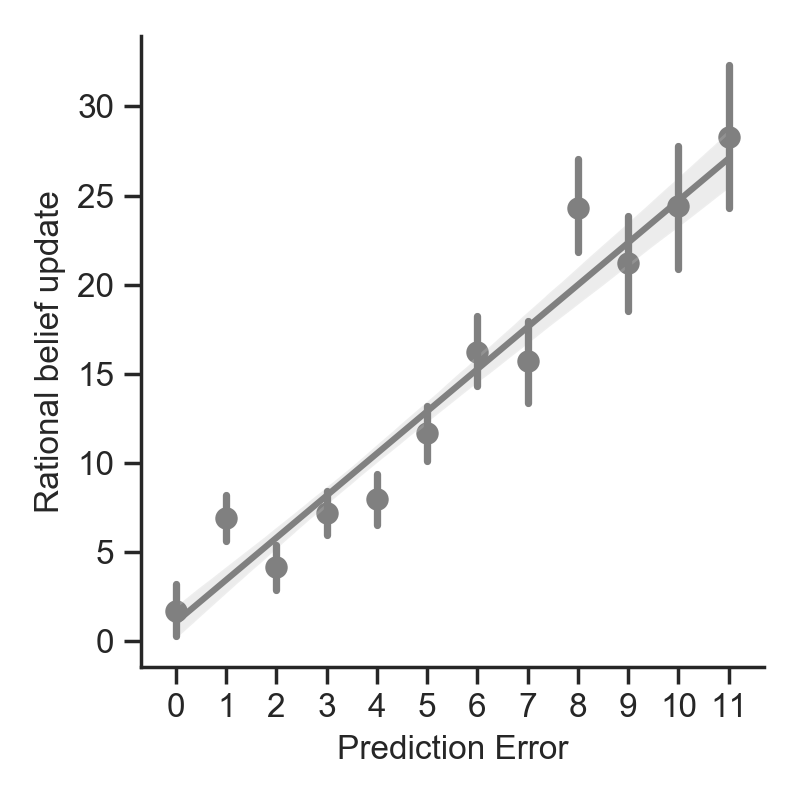

                            OLS Regression Results                            
Dep. Variable:                RdeltaB   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     682.4
Date:                Tue, 16 Jun 2020   Prob (F-statistic):          4.31e-143
Time:                        13:19:00   Log-Likelihood:                -29612.
No. Observations:                6466   AIC:                         5.923e+04
Df Residuals:                    6464   BIC:                         5.924e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0800      0.535      2.020      0.0

In [25]:
# Group and average data within participant and PE bin
AVDATA = DATA.loc[DATA["cond"]==1,:].groupby(["partnum", "PE"], as_index=False).mean()

# Plotting
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.regplot(x="PE", y="RdeltaB", x_estimator=np.mean, data=AVDATA, \
            color="gray", ci=95, ax=ax)
sns.despine()
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xlabel("Prediction Error");
ax.set_ylabel("Rational belief update");

print(sm.OLS(AVDATA["RdeltaB"], sm.add_constant(AVDATA["PE"])).fit().summary())

plt.tight_layout()
#plt.savefig('/Users/mada/Desktop/fig1rep.tif', dpi=300, format="tiff")

## 4 $-$ Linear mixed effects model using ``statsmodels`` in Python

Let's build up the model and measure in-sample prediction RMSE as a performance measure for our evolving models. To begin, add a z-scored PE such that regression coefficients are comparable across categorical and linear predictors.

In [26]:
DATAexp = DATA[DATA["cond"]==1]

In [27]:
if "scaledPE" not in DATAexp:
    DATAexp.insert(4, "scaledPE", DATAexp[["PE"]].apply(stats.zscore))
map_dict = {1: "D", 2: "R", 3: "aN"}
if "pid" in DATAexp:
    DATAexp = DATAexp.drop("pid", axis=1)
    DATAexp = DATAexp.drop("iid", axis=1)
DATAexp.insert(12,"pid",DATAexp["partideology"].map(map_dict))
DATAexp.insert(10,"iid",DATAexp["itemideology"].map(map_dict))

DATAexp.head()

,RdeltaB,deltaB,signedPE,binnedPE,scaledPE,PE,Bpre,RpreI,overunder,supportagainst,iid,itemideology,maxPE,pid,itemnum,date,study,cond,partideology,partnum
180,30.0,30.0,0.0,0,-1.402241,0.0,70.0,30.0,1.0,1.0,aN,3.0,10.0,D,0.0,1.0,2.0,1.0,1.0,5.0
181,-0.0,0.0,-1.0,1,-1.050230,1.0,100.0,100.0,1.0,1.0,aN,3.0,9.0,D,1.0,1.0,2.0,1.0,1.0,5.0
182,100.0,-100.0,-3.0,1,-0.346207,3.0,100.0,100.0,1.0,1.0,aN,3.0,7.0,D,2.0,1.0,2.0,1.0,1.0,5.0
183,0.0,0.0,-6.0,2,0.709826,6.0,100.0,0.0,0.0,1.0,aN,3.0,6.0,D,3.0,1.0,2.0,1.0,1.0,5.0
184,0.0,0.0,-3.0,1,-0.346207,3.0,100.0,0.0,0.0,1.0,aN,3.0,8.0,D,4.0,1.0,2.0,1.0,1.0,5.0


## 5 $-$ Linear mixed effects model using ``lme4`` in R
Crossed random effects are not supported in ``statsmodels``. One workaround is to directly call ``lme4`` in R from the ipython environment. Let's launch an R environment:

Import the R package ``lme4`` (``RRuntimeWarning: Loading required package: Matrix`` is normal!) Also, for whatever reason the kernel will die if we load the ``lme4`` and ``lmerTest`` libraries in the same cell??

In [28]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
# %R library(lme4)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
%R library(lmerTest)

array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

- Push data to the R side (``FutureWarning: from_items is deprecated`` is normal)

In [32]:
if "scaledRpreI" not in DATAexp:
    DATAexp.insert(7, "scaledRpreI", DATAexp[["RpreI"]].apply(stats.zscore))
map_dict = {1: "D", 2: "R", 3: "aN"}
if "pid" in DATAexp:
    DATAexp = DATAexp.drop("pid", axis=1)
    DATAexp = DATAexp.drop("iid", axis=1)
DATAexp.insert(12,"pid",DATAexp["partideology"].map(map_dict))
DATAexp.insert(10,"iid",DATAexp["itemideology"].map(map_dict))

DATAexp.head()

,RdeltaB,deltaB,signedPE,binnedPE,scaledPE,PE,Bpre,scaledRpreI,RpreI,overunder,...,supportagainst,itemideology,pid,maxPE,itemnum,date,study,cond,partideology,partnum
180,30.0,30.0,0.0,0,-1.402241,0.0,70.0,-0.843005,30.0,1.0,...,1.0,3.0,D,10.0,0.0,1.0,2.0,1.0,1.0,5.0
181,-0.0,0.0,-1.0,1,-1.050230,1.0,100.0,1.491114,100.0,1.0,...,1.0,3.0,D,9.0,1.0,1.0,2.0,1.0,1.0,5.0
182,100.0,-100.0,-3.0,1,-0.346207,3.0,100.0,1.491114,100.0,1.0,...,1.0,3.0,D,7.0,2.0,1.0,2.0,1.0,1.0,5.0
183,0.0,0.0,-6.0,2,0.709826,6.0,100.0,-1.843341,0.0,0.0,...,1.0,3.0,D,6.0,3.0,1.0,2.0,1.0,1.0,5.0
184,0.0,0.0,-3.0,1,-0.346207,3.0,100.0,-1.843341,0.0,0.0,...,1.0,3.0,D,8.0,4.0,1.0,2.0,1.0,1.0,5.0


In [33]:
%Rpush DATAexp

In [34]:
%%R

M <- lmer(RdeltaB ~ PE*partideology + scaledRpreI + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ PE * partideology + scaledRpreI + (1 | partnum) + (1 |  
    itemnum)
   Data: DATAexp

REML criterion at convergence: 210708.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5975 -0.7315  0.0842  0.7253  3.0546 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  25.92    5.091  
 itemnum  (Intercept)  60.34    7.768  
 Residual             715.48   26.749  
Number of obs: 22320, groups:  partnum, 620; itemnum, 36

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         6.0029     1.7467   110.3692   3.437 0.000831 ***
PE                  2.2584     0.2043 22245.4459  11.053  < 2e-16 ***
partideology       -0.9424     0.7475  2080.4936  -1.261 0.207549    
scaledRpreI        16.4256     0.1913 22178.0697  85.858  < 2e-16 ***
PE:partideology    -0.5748     0.1286 22231.0295  -4.470 7.84e-06

- Run the linear mixed model fit in full R syntax

In [35]:
%%R

M <- lmer(RdeltaB ~ PE:iid:pid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ PE:iid:pid + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 217073.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2378 -0.5279 -0.0261  0.5551  3.5937 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  31.38    5.602  
 itemnum  (Intercept)  91.49    9.565  
 Residual             952.63   30.865  
Number of obs: 22320, groups:  partnum, 620; itemnum, 36

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   2.403e+00  1.656e+00 3.886e+01   1.451    0.155    
PE:iidaN:pidD 2.377e+00  1.634e-01 1.597e+04  14.548  < 2e-16 ***
PE:iidD:pidD  2.277e+00  1.613e-01 1.586e+04  14.119  < 2e-16 ***
PE:iidR:pidD  2.161e+00  1.598e-01 1.773e+04  13.521  < 2e-16 ***
PE:iidaN:pidR 1.770e+00  1.632e-01 1.608e+04  10.847  < 2e-16 ***
PE:iidD:pidR  1.264e+00  1.605e-01 1.607e+04  

In [36]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ scaledRpreI + PE + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 210761.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6891 -0.7286  0.0880  0.7243  3.0899 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  28.50    5.339  
 itemnum  (Intercept)  60.14    7.755  
 Residual             716.09   26.760  
Number of obs: 22320, groups:  partnum, 620; itemnum, 36

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 4.629e+00  1.353e+00 4.041e+01   3.421  0.00144 ** 
scaledRpreI 1.642e+01  1.915e-01 2.216e+04  85.764  < 2e-16 ***
PE          1.402e+00  7.187e-02 2.214e+04  19.506  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scldRI
scaledRpreI  0.019       
PE          -0.212 -0.090


- Pull data back to the Python side

In [38]:
%Rpush DATAexp

In [41]:
%%R

M <- lmer(RdeltaB ~ PE*pid*iid + (1 | partnum) + (1 | itemnum), data = DATAexp)
# M <- lmer(RdeltaB ~ PE + pid + PE:pid + PE:iid + PE:pid:iid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs_part <- ranef(M)$partnum
rfs_item <- ranef(M)$itemnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ PE * pid * iid + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 217043

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2371 -0.5276 -0.0262  0.5568  3.5883 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  31.22    5.588  
 itemnum  (Intercept)  86.64    9.308  
 Residual             952.39   30.861  
Number of obs: 22320, groups:  partnum, 620; itemnum, 36

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   7.509e+00  2.850e+00  4.023e+01   2.635   0.0119 *  
PE            2.274e+00  1.898e-01  2.211e+04  11.979   <2e-16 ***
pidR         -1.228e+00  1.309e+00  9.110e+03  -0.938   0.3480    
iidD         -5.983e+00  4.010e+00  3.946e+01  -1.492   0.1437    
iidR         -6.647e+00  4.001e+00  3.907e+01  -1.662   0.1046    
PE:pidR      -4.867e-01  2.506e-01  2.

In [42]:
%Rpull rfs_part
%Rpull rfs_item
%Rpull ffs

In [43]:
# Fixed effects can be used to show linear predictions under the mixed model
fixedeffects = [ffs[i] for i in range(len(ffs))]
# Random effects can be used to show linear data with the random effects already removed
randomeffects = [[rfs_part[0][i] for i in range(len(rfs_part[0]))], [rfs_item[0][i] for i in range(len(rfs_item[0]))]]
rm_re = np.array([randomeffects[0][i] + randomeffects[1][j] for i in range(len(randomeffects[0])) for j in range(len(randomeffects[1]))])
if "RdeltaB_corrected" in DATAexp:
    DATAexp = DATAexp.drop("RdeltaB_corrected", axis=1)
DATAexp.insert(1,"RdeltaB_corrected",DATAexp["RdeltaB"] - rm_re)
DATAexp.head()

,RdeltaB,RdeltaB_corrected,deltaB,signedPE,binnedPE,scaledPE,PE,Bpre,scaledRpreI,RpreI,...,supportagainst,itemideology,pid,maxPE,itemnum,date,study,cond,partideology,partnum
180,30.0,28.164629,30.0,0.0,0,-1.402241,0.0,70.0,-0.843005,30.0,...,1.0,3.0,D,10.0,0.0,1.0,2.0,1.0,1.0,5.0
181,-0.0,-3.700909,0.0,-1.0,1,-1.050230,1.0,100.0,1.491114,100.0,...,1.0,3.0,D,9.0,1.0,1.0,2.0,1.0,1.0,5.0
182,100.0,110.075621,-100.0,-3.0,1,-0.346207,3.0,100.0,1.491114,100.0,...,1.0,3.0,D,7.0,2.0,1.0,2.0,1.0,1.0,5.0
183,0.0,1.474039,0.0,-6.0,2,0.709826,6.0,100.0,-1.843341,0.0,...,1.0,3.0,D,6.0,3.0,1.0,2.0,1.0,1.0,5.0
184,0.0,3.934019,0.0,-3.0,1,-0.346207,3.0,100.0,-1.843341,0.0,...,1.0,3.0,D,8.0,4.0,1.0,2.0,1.0,1.0,5.0


<IPython.core.display.Javascript object>


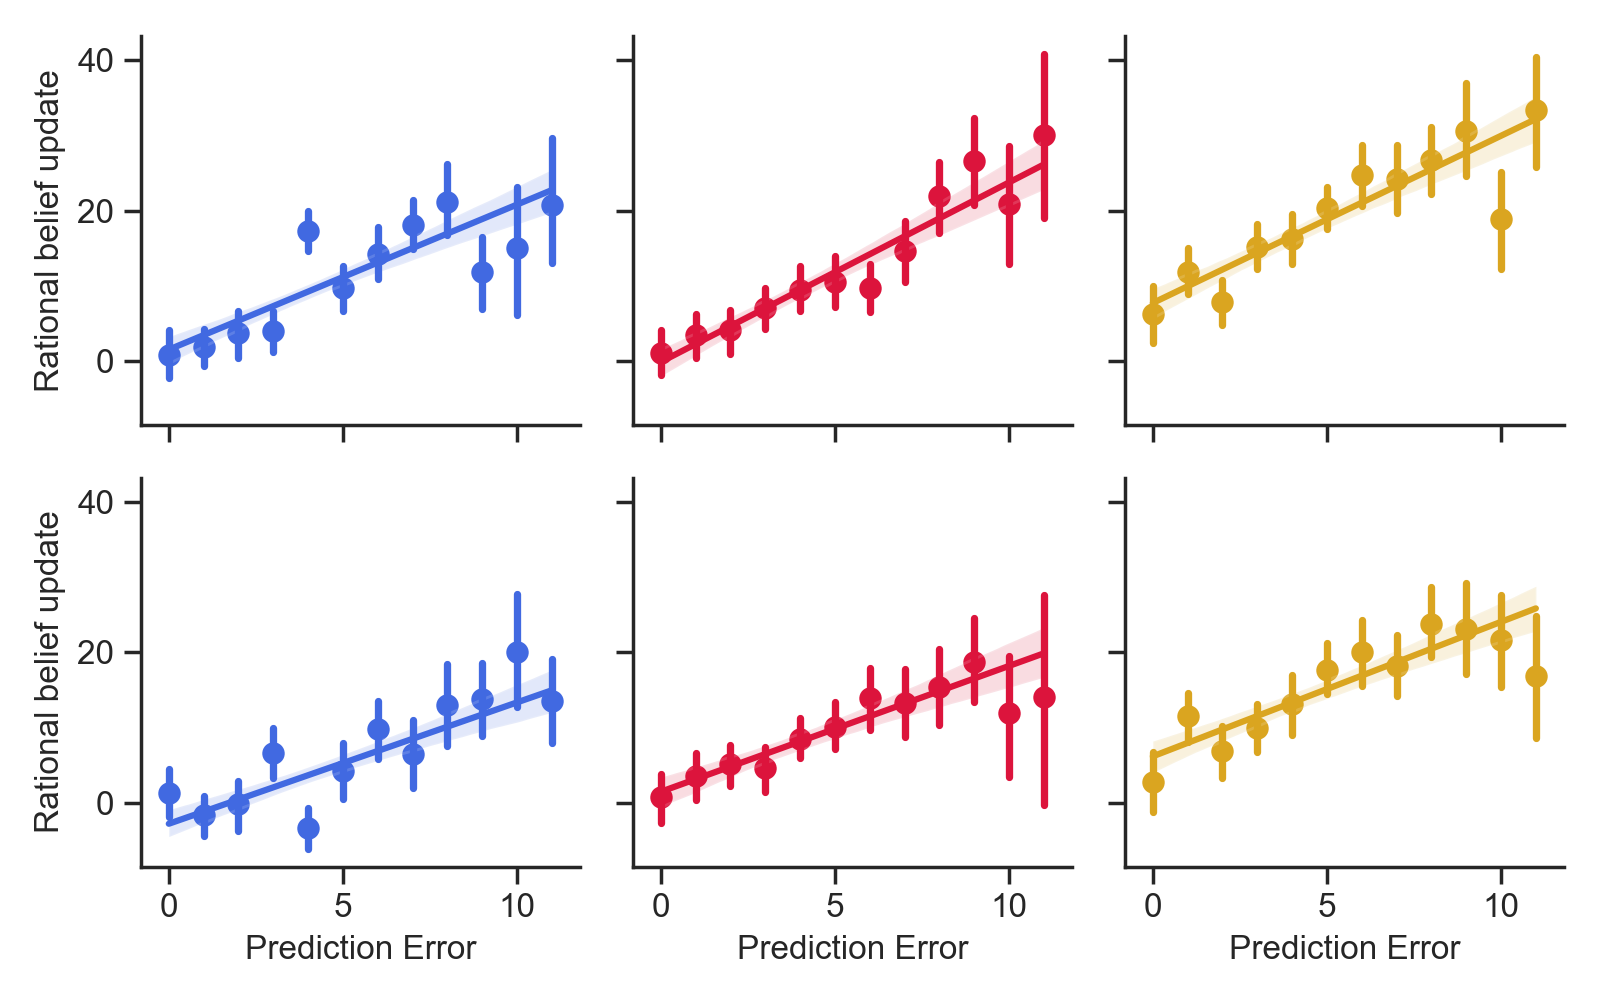

In [44]:
# Declare groups over which to split here:
grp1 = "partideology"
grp2 = "itemideology"

fig, ax = plt.subplots(len(DATA[grp1].unique()), len(DATA[grp2].unique()), figsize=(8,5), sharey=True)
colors = ["royalblue", "crimson", "goldenrod"]

# Split dataframe into groups, where grpDATA is a subsampled dataframe of DATA with one split's data at a time
for name, grpDATA in DATAexp.groupby([grp1, grp2]):
    name = np.array(name, dtype=int) - 1
    cax = ax[name[0],name[1]]
    # Average the split's items within participants
    AVDATA = grpDATA.groupby(["partnum", "PE"], as_index=False).mean()
    
    # Plotting  x_estimator=np.mean
#     sns.regplot(x="PE", y="RdeltaB", scatter=True, data=AVDATA, \
#                 color=colors[name[-1]], ci=99, x_jitter=.1, marker=".", scatter_kws={'s':2}, \
#                 ax=cax)
    sns.regplot(x="PE", y="RdeltaB_corrected", x_estimator=np.mean, data=AVDATA, \
                color=colors[name[-1]], ci=95, ax=cax)
    sns.despine()
    if name[0] == len(DATA[grp1].unique())-1:
        cax.set_xlabel("Prediction Error");
    else:
        cax.set_xticklabels("");
        cax.set_xlabel("");
    if name[1] == 0:
        cax.set_ylabel("Rational belief update");
    else:
        cax.set_ylabel("");
    
plt.tight_layout()
#plt.savefig('/Users/mada/Desktop/fig3rep.tif', dpi=300, format="tiff")